<a href="https://colab.research.google.com/github/hbgit/walletstockanalysis/blob/main/ReviewMyWalletStonks_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import json
# Import the plotting library
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

In [ ]:
#PRIO3 = yf.Ticker("PRIO3.SA")
PRIO3 = yf.Ticker("VOO")
print(PRIO3.info)

{'exchange': 'PCX', 'shortName': 'Vanguard S&P 500 ETF', 'longName': 'Vanguard 500 Index Fund', 'exchangeTimezoneName': 'America/New_York', 'exchangeTimezoneShortName': 'EST', 'isEsgPopulated': False, 'gmtOffSetMilliseconds': '-18000000', 'quoteType': 'ETF', 'symbol': 'VOO', 'messageBoardId': 'finmb_28117396', 'market': 'us_market', 'annualHoldingsTurnover': None, 'enterpriseToRevenue': None, 'beta3Year': 1, 'profitMargins': None, 'enterpriseToEbitda': None, '52WeekChange': None, 'morningStarRiskRating': None, 'forwardEps': None, 'revenueQuarterlyGrowth': None, 'fundInceptionDate': 1283817600, 'annualReportExpenseRatio': None, 'totalAssets': 747471699968, 'bookValue': None, 'fundFamily': 'Vanguard', 'lastFiscalYearEnd': None, 'netIncomeToCommon': None, 'trailingEps': None, 'lastDividendValue': None, 'SandP52WeekChange': None, 'priceToBook': None, 'nextFiscalYearEnd': None, 'yield': 0.0164, 'mostRecentQuarter': None, 'enterpriseValue': None, 'priceHint': 2, 'threeYearAverageReturn': 0.1

**Stock Wallet**

In [3]:
ticket_company_shares = ['ABBV','PEP','PLD','KO','STOR','PRU','MSFT','VZ','T','GOOGL','AMZN']

In [100]:
def check_sharpe_ration(list_tickets, dict_percent_book, portfolio_size):
  """ Based on https://www.linkedin.com/pulse/calculating-portfolio-sharpe-ratio-python-f%C3%A1bio-neves/ """
  
  data = yf.download(list_tickets,period = "5y")['Adj Close']
  
  # 'Norm return'
  df_rt = pd.DataFrame() 
  for symbol in data.columns: 
    if bool(dict_percent_book) == False:
      # position 
      df_rt[symbol] = ( (data[symbol] / data[symbol][0]) * .25 ) * portfolio_size#allocation
    #TODO when is not empty

  plt.style.use('fivethirtyeight')
  df_rt.plot(figsize=(10,8))

  #TODO: fix graph
  plt.style.use('fivethirtyeight')
  df_rt['Total Pos'] = df_rt.sum(axis=1)
  df_rt['Total Pos'].plot(figsize=(10,8))
  cumulative_return = 100 * ( df_rt['Total Pos'][-1]/df_rt['Total Pos'][0]-1 )
  print('{:.2f}%'.format(cumulative_return))
  
  # sharp
  df_rt['Daily Return'] = df_rt['Total Pos'].pct_change(1)
  Sharpe_Ratio = df_rt['Daily Return'].mean() / df_rt['Daily Return'].std()

  # There are 252 trading days in the year TODO: automatic get this data
  A_Sharpe_Ratio = (252**0.5) * Sharpe_Ratio
  print(A_Sharpe_Ratio)

  

[*********************100%***********************]  11 of 11 completed
73.02%
0.6353439916762045


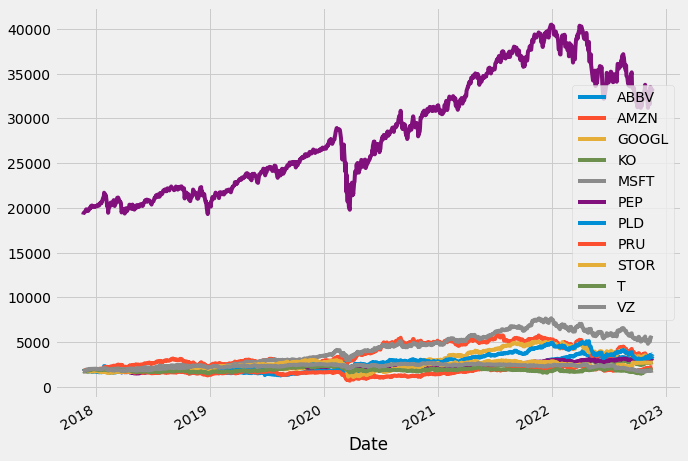

In [101]:
check_sharpe_ration(ticket_company_shares,{},7000)

In [ ]:
#earningsGrowth; yield; totalRevenue
metric_company_shares = [
    'marketCap',
    'revenueGrowth',
    'pegRatio',
    'returnOnAssets',
    'returnOnEquity',
    'profitMargins',
    'currentRatio',
    'debtToEquity',
    'payoutRatio',
    'recommendationMean',
    'recommendationKey',
    'totalDebt',
    'sector',
    'dividendYield',
    'averageVolume',
    'totalRevenue'
]

In [ ]:
df = pd.DataFrame(index=ticket_company_shares,columns=metric_company_shares)

In [ ]:
def get_fundamental_data(df):
  for symbol in df.index:
    get_sym_info = yf.Ticker(symbol)
    print("Getting symbol: " + symbol)    
    for metric in df.columns:        
      #print(get_sym_info.info[metric])
      df.loc[symbol,metric] = get_sym_info.info[metric]    
  return df
      

In [ ]:
# Defining rules to check fundamentals
# gt -> great than >= 
rulesFundmentals_gt_company_shares = {
    'marketCap' : 200000000000,
    'revenueGrowth' : 0.052,
    'pegRatio' : 2.0,
    'returnOnAssets' : 0.08000,
    'returnOnEquity' : 0.20000,
    'profitMargins' : 0.11282,
    'currentRatio' : 1.0,
    'debtToEquity' : 11.00,   
    'averageVolume' : 1700000
}

In [ ]:
df = get_fundamental_data(df)

Getting symbol: ABBV
Getting symbol: PEP
Getting symbol: PLD
Getting symbol: KO
Getting symbol: STOR
Getting symbol: PRU
Getting symbol: MSFT
Getting symbol: VZ
Getting symbol: T
Getting symbol: GOOGL
Getting symbol: AMZN


In [ ]:
# Print Bar Chart
def print_bar_chart_from_json(json_file):
  print(json_file)
  #s = pd.Series(json_file, name='DateValue')
  df = pd.DataFrame(json_file.items(), columns=['Ticket', 'Value'])
  fig = px.bar(df, x='Ticket', y='Value',
             color='Value',
             labels={'pop':'population of Canada'}, height=400)
  fig.show()


In [ ]:
def check_peformace_last_months(list_symbol):
    # Collect data from the last 6 months  
    #print(list_symbol)  
    data = yf.download(list_symbol,period = "6mo")['Adj Close']
    flag_series = False
   
    if type(data) is pd.Series:
      flag_series = True
      single_symbol = list_symbol[0]
      data = pd.DataFrame({'Date':data.index, single_symbol:data.values})
      #set column as index
      data = data.set_index('Date')

    # https://capitalresearch.com.br/blog/calcular-rentabilidade/
    # Return  
    dict_return = {}  
    for symbol in data.columns:
      if not pd.isna(data[symbol].iloc[0]):
        dict_return[symbol] = ((data[symbol].iloc[-1]/data[symbol].iloc[0])*100)-100
      else:
        dict_return[symbol] = ((data[symbol].iloc[-1]/data[symbol].iloc[1])*100)-100

    print(dict_return)
    worst_return = {}
    flag_has_bad_return = False
    for e in dict_return.keys():
      if dict_return[e] <= -20.00:
        flag_has_bad_return = True
        worst_return[e] = dict_return[e]
    
    #print(json.dumps(worst_return, sort_keys=True, indent=4))
    if flag_has_bad_return:
      print_bar_chart_from_json(worst_return)

    # ----------------- Plot all the close prices  ----------------- 
    # Pandas dataframe. pct_change() function calculates the percentage change between the current and a prior element.
    # Return cumulative product over a DataFrame or Series axis.
    # The next step is to calculate the simple daily returns of the stocks. The formula to calculate this rate is to divide each day by the previous day minus 1.   
    df = (data.pct_change()+1).cumprod()
    if not flag_series:
      df = df.reset_index()
      fig = px.line(df, x="Date", y=df.columns)
      fig.show()
    else:      
      df = df.reset_index()
      fig = px.line(df, x="Date", y=single_symbol)
      fig.show()
    
    

In [ ]:
def check_fundamentals_data_shares(df, dict_rules_fundamentals):  
  
  rules_broken_by_symbol = []
  metric_broken_by_symbol = {}

  for symbol in df.index:
    count_broken_rules = 0
    tmp_metrics = []         
    
    for metric in df.columns:                                               
      if metric in dict_rules_fundamentals:                        
        if df.loc[symbol,metric] is not None:                        
          if df.loc[symbol,metric] < dict_rules_fundamentals[metric]:
            count_broken_rules += 1 
            tmp_metrics.append(df.loc[symbol,metric])
            tmp_metrics.append(dict_rules_fundamentals[metric])              
            metric_broken_by_symbol[symbol] = tmp_metrics
          if metric == "payoutRatio":
            if df.loc[symbol,metric] > 1.0:
              count_broken_rules += 1
              tmp_metrics.append(df.loc[symbol,metric])
              tmp_metrics.append(dict_rules_fundamentals[metric])              
              metric_broken_by_symbol[symbol] = tmp_metrics
          if metric == "recommendationKey":
            if df.loc[symbol,metric] ==  "sell":
              count_broken_rules += 1
              tmp_metrics.append(df.loc[symbol,metric])
              tmp_metrics.append(dict_rules_fundamentals[metric])              
              metric_broken_by_symbol[symbol] = tmp_metrics
            elif df.loc[symbol,metric] ==  "hold":
              if df.loc[symbol,"recommendationMean"] > 3.5:
                count_broken_rules += 1
                tmp_metrics.append(df.loc[symbol,"recommendationMean"])
                tmp_metrics.append(3.6)   

      if count_broken_rules >= 3: # number of rules that was broken        
        rules_broken_by_symbol.append(symbol)
      else:
        if symbol in metric_broken_by_symbol.keys():
          metric_broken_by_symbol.pop(symbol) 
    
    #try:      
    #except Exception as e:
    #  print (symbol, 'not found')

  # Useful data
  print("Stocks that broken the rules: ")  
  print(json.dumps(metric_broken_by_symbol, sort_keys=True, indent=4))
  check_peformace_last_months(rules_broken_by_symbol)


In [ ]:
check_fundamentals_data_shares(df, rulesFundmentals_gt_company_shares)

Stocks that broken the rules: 
{
    "ABBV": [
        0.033,
        0.052,
        -27.35,
        2.0,
        0.928,
        1.0
    ],
    "AMZN": [
        -42.09,
        2.0,
        0.02,
        0.08,
        0.08776,
        0.2,
        0.022550002,
        0.11282,
        0.937,
        1.0
    ],
    "PLD": [
        104076812288,
        200000000000,
        -5.22,
        2.0,
        0.02723,
        0.08,
        0.11095,
        0.2
    ],
    "PRU": [
        39710879744,
        200000000000,
        -0.054,
        0.052,
        -2.24,
        2.0,
        -0.00027000002,
        0.08,
        0.00843,
        0.2,
        0.0053399997,
        0.11282
    ],
    "STOR": [
        8961146880,
        200000000000,
        0.03208,
        0.08,
        0.06142,
        0.2
    ],
    "T": [
        135555547136,
        200000000000,
        -0.041,
        0.052,
        -1.6,
        2.0,
        0.04249,
        0.08,
        0.119219996,
        0.2,
      

In [ ]:
# ETFs analysis

In [ ]:
def check_fundamentals_data_etfs(df, dict_rules_fundamentals):  
  
  rules_broken_by_symbol = []
  metric_broken_by_symbol = {}

  for symbol in df.index:
    count_broken_rules = 0
    tmp_metrics = []         
    
    for metric in df.columns:                                               
      if metric in dict_rules_fundamentals:                        
        if df.loc[symbol,metric] is not None:                        
          if df.loc[symbol,metric] < dict_rules_fundamentals[metric]:
            count_broken_rules += 1 
            tmp_metrics.append(df.loc[symbol,metric])
            tmp_metrics.append(dict_rules_fundamentals[metric])              
            metric_broken_by_symbol[symbol] = tmp_metrics
          if metric == "beta3Year":
            if df.loc[symbol,metric] > 1.2:
              count_broken_rules += 1
              tmp_metrics.append(df.loc[symbol,metric])
              tmp_metrics.append(dict_rules_fundamentals[metric])
              metric_broken_by_symbol[symbol] = tmp_metrics
      if count_broken_rules >= 3: # number of rules that was broken        
        rules_broken_by_symbol.append(symbol)
      else:
        if symbol in metric_broken_by_symbol.keys():
          metric_broken_by_symbol.pop(symbol) 
    
    #try:      
    #except Exception as e:
    #  print (symbol, 'not found')

  # Useful data
  print("Stocks that broken the rules: ") 
  print(metric_broken_by_symbol)
  #print(json.dumps(metric_broken_by_symbol, sort_keys=True, indent=4))
  check_peformace_last_months(rules_broken_by_symbol)

In [ ]:
# https://www.investopedia.com/terms/b/beta.asp
# Note pegratio and others were removed
# they have none values
metric_ETFs = [
    'quoteType',
    'beta3Year',
    'trailingAnnualDividendYield',
    'yield', 
    'marketCap', 
    'totalAssets',
    'averageVolume',
    'category'
]

In [ ]:
# Defining rules to check fundamentals
# gt -> great than >= 
rulesFundmentals_gt_etfs = {
    'beta3Year' : 1.1,
    'trailingAnnualDividendYield' : 0.011,
    'yield' : 0.011,
    'totalAssets' : 4730926080,
    'averageVolume' : 621942
}

In [ ]:
ticket_etfs_shares = ['VOO', 'VNQ', 'CIBR']

In [ ]:
df_etfs = pd.DataFrame(index=ticket_etfs_shares,columns=metric_ETFs)

In [ ]:
df_etfs = get_fundamental_data(df_etfs)

Getting symbol: VOO
Getting symbol: VNQ
Getting symbol: CIBR


In [ ]:
df_etfs

,quoteType,beta3Year,trailingAnnualDividendYield,yield,marketCap,totalAssets,averageVolume,category
VOO,ETF,1,0.014969,0.0164,None,747471699968,4684135,Large Blend
VNQ,ETF,1.03,0.039284,0.0376,None,63765606400,5642975,Real Estate
CIBR,ETF,1.04,0,0.0073,None,5117977600,583689,Technology


In [ ]:
check_fundamentals_data_etfs(df_etfs, rulesFundmentals_gt_etfs)

Stocks that broken the rules: 
{'CIBR': [1.04, 1.1, 0, 0.011, 0.0073, 0.011, 583689, 621942]}
[*********************100%***********************]  1 of 1 completed
{'CIBR': 0.4717570120806158}


In [ ]:
# https://kernc.github.io/backtesting.py/doc/examples/Parameter%20Heatmap.html
# https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec
# 

Analyzing Brasil Stonks

In [ ]:
# 'BOVA11.SA' 'IVVB11.SA'
ticket_BRA_shares = ['ABEV3.SA','ASAI3.SA','BPAC11.SA','GOAU4.SA','ITUB4.SA','PETR4.SA','PRIO3.SA','RANI3.SA','TAEE11.SA','TRPL4.SA','VALE3.SA']

In [ ]:
import plotly.graph_objects as go

def generate_sankey_chart(df_tickets):
  """ Sector by ticket """
  lab_list = df_tickets.index.values.tolist() + list(set(df_tickets['sector'].values.tolist()))
  
  fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = lab_list
      #color = "blue"
    ),
    link = dict(
      # indices correspond to labels, eg PETR3.SA
      source = list(map(lambda x: df_tickets.index.values.tolist().index(x), df_tickets.index.values.tolist())), 
      target = list(map(lambda x: lab_list.index(str(df_tickets.loc[x,'sector'])), df_tickets.index.values.tolist())),
      value = [1, 1, 1, 1, 1, 1, 1, 1, 1] # number of tickets
  ))])

  fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
  fig.show()


In [ ]:
df_bra = pd.DataFrame(index=ticket_BRA_shares,columns=metric_company_shares)

In [ ]:
df_bra = get_fundamental_data(df_bra) #error sector

Getting symbol: ABEV3.SA
Getting symbol: ASAI3.SA
Getting symbol: BPAC11.SA
Getting symbol: GOAU4.SA
Getting symbol: ITUB4.SA
Getting symbol: PETR4.SA
Getting symbol: PRIO3.SA
Getting symbol: RANI3.SA
Getting symbol: TAEE11.SA
Getting symbol: TRPL4.SA
Getting symbol: VALE3.SA


In [ ]:
df_bra.sort_values('debtToEquity')

,marketCap,revenueGrowth,pegRatio,returnOnAssets,returnOnEquity,profitMargins,currentRatio,debtToEquity,payoutRatio,recommendationMean,recommendationKey,totalDebt,sector,dividendYield,averageVolume,totalRevenue
ABEV3.SA,252016377856,0.113,1.93,0.07882,0.15085,0.16575,1.188,3.735,0.7305,2.6,hold,3419270912,Consumer Defensive,0.0423,26873100,79026618368
GOAU4.SA,13960438784,0.201,0.06,0.17753,0.38091,0.06173,2.259,27.879,0.4919,1.7,buy,13434730496,Basic Materials,0.1259,9008441,86170910720
VALE3.SA,403616956416,-0.368,0.02,0.16793,0.50592,0.41553,1.322,43.861,0.5717,2.4,buy,84964999168,Basic Materials,0.1014,38104409,249432997888
TRPL4.SA,17181577216,0.103,0.84,0.08117,0.18785,0.47454,7.491,49.838,0.3457,3.2,hold,7991869952,Utilities,0.1182,1900375,5961070080
PETR4.SA,381152002048,0.544,0.11,0.17079,0.41849,0.2842,1.313,67.975,0.955,2.4,buy,280637014016,Energy,0.3116,97244059,568385011712
PRIO3.SA,32473788416,0.832,0.6,0.15698,0.39519,0.43876,8.198,81.33,0,1.8,buy,6646010880,Energy,None,13653479,6121811968
RANI3.SA,2192445184,0.064,None,0.12233,0.3754,0.21248,2.787,109.241,0.4284,2.5,buy,1127901056,Consumer Cyclical,0.0448,1344306,1683387008
TAEE11.SA,41381343232,-0.063,-1.43,0.09853,0.30798,0.63098,3.09,121.385,None,3.8,underperform,8684054528,Utilities,0.0851,2013762,3302647040
ASAI3.SA,26391400448,0.275,-2.19,0.05956,0.44722,0.02675,0.909,554.604,None,1.9,buy,19938000896,Consumer Defensive,0.0128,12738648,50121998336
BPAC11.SA,87271604224,0.63,0.62,0.0203,0.19075,0.30585,None,None,None,2.3,buy,195370975232,Financial Services,0.0169,11569633,23310096384


In [ ]:
generate_sankey_chart(df_bra)

In [ ]:
## Defining rules to check fundamentals
# gt -> great than >= 
rulesFundmentals_gt_company_shares_BR = {
    'marketCap' : 2000000000,
    'revenueGrowth' : 0.06,
    'pegRatio' : 0.12,
    'returnOnAssets' : 0.02,
    'returnOnEquity' : 0.18,
    'profitMargins' : 0.2,
    'currentRatio' : 1.3,
    'debtToEquity' : 31.61,   
    'averageVolume' : 1900000
}

In [ ]:
check_fundamentals_data_shares(df_bra, rulesFundmentals_gt_company_shares_BR)

Stocks that broken the rules: 
{
    "ABEV3.SA": [
        0.15085,
        0.18,
        0.16575001,
        0.2,
        1.188,
        1.3,
        3.735,
        31.61
    ],
    "ASAI3.SA": [
        -2.19,
        0.12,
        0.02675,
        0.2,
        0.909,
        1.3
    ],
    "GOAU4.SA": [
        0.06,
        0.12,
        0.061729997,
        0.2,
        27.879,
        31.61
    ],
    "ITUB4.SA": [
        -0.056,
        0.06,
        0.01364,
        0.02,
        0.17457001,
        0.18
    ]
}
[*********************100%***********************]  4 of 4 completed
{'ABEV3.SA': 8.57726524760703, 'ASAI3.SA': 27.52114851923291, 'GOAU4.SA': 12.936174108627, 'ITUB4.SA': 6.429707045276373}
